## Paquid Data Test

In [17]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import torch
from typing import cast

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [18]:
paquid = pd.read_csv("data/paquid.csv")  # type: ignore

In [19]:
def get_trajectory(id: int):
    s = (
        paquid.loc[paquid["ID"].eq(id)]  # type: ignore
        .groupby("HIER")["age"]
        .min()
        .reindex(range(4))
        .dropna()
    )
    s = s[s >= s.cummax()]
    return [(float(a), int(k)) for k, a in s.items()]  # type: ignore


def get_last_visit_age(id: int):
    return paquid[paquid["ID"] == id]["age"].max()


def get_t(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)


def get_X(id: int):
    return torch.tensor(
        paquid.loc[paquid["ID"] == id, ["CEP", "male"]].iloc[0].to_numpy()
    )


def get_Y(id: int):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

In [20]:
def prepare_all(ids: list[int]):
    trajectories0 = [get_trajectory(i) for i in ids]
    c0 = torch.tensor([get_last_visit_age(i) for i in ids]).view(-1, 1)
    t0 = torch.nn.utils.rnn.pad_sequence(
        [get_t(i) for i in ids], batch_first=True, padding_value=torch.nan
    )
    y0 = torch.nn.utils.rnn.pad_sequence(
        [get_Y(i) for i in ids], batch_first=True, padding_value=torch.nan
    )[..., None]
    x = torch.cat([get_X(i).view(1, -1) for i in ids], dim=0)

    t_min, t_max = torch.nanquantile(t0, 0).item(), torch.nanquantile(t0, 1).item()
    y_min, y_max = torch.nanquantile(y0, 0).item(), torch.nanquantile(y0, 1).item()

    def normalize_t(t: torch.Tensor | float):
        return (2.0 * t - (t_max + t_min)) / (t_max - t_min)

    def normalize_y(y: torch.Tensor):
        return (2.0 * y - (y_max + y_min)) / (y_max - y_min)

    y = normalize_y(y0)
    trajectories = [[(normalize_t(m), s) for (m, s) in traj] for traj in trajectories0]
    t = normalize_t(t0)
    c = normalize_t(c0)

    return x, t, y, trajectories, c

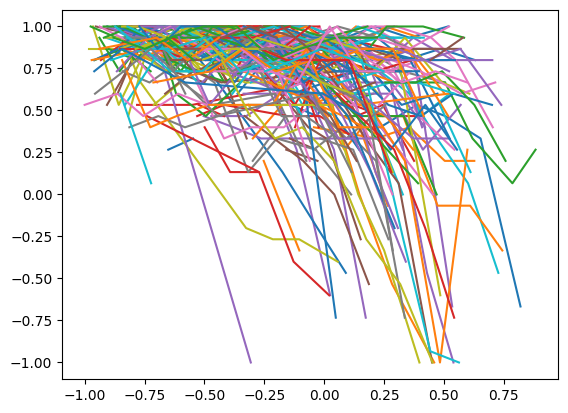

In [21]:
ids = random.sample(range(1, 501), 300)

x, t, y, trajectories, c = prepare_all(ids)

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [22]:
buckets = build_buckets(trajectories)

In [23]:
def reg(t: torch.Tensor, psi: torch.Tensor):
    a, b, c = psi.chunk(3, dim=-1)
    return (a * torch.tanh((t - c) / b)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + b
    psi[..., 0] = psi[..., 0].sigmoid()
    psi[..., 1] = -psi[..., 1].exp()
    return psi


surv = {key: HazardFns(jmstate.functions.Exponential(1.0), reg) for key in buckets}

init_alphas = {key: torch.zeros(1) for key in buckets}
init_betas = {key: torch.zeros(2) for key in buckets}

init_params = ModelParams(
    torch.zeros(3),
    repr_from_cov(torch.eye(3), method="full"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
    extra=[p for val in surv.values() for p in val[0].parameters()],
)

model_design = ModelDesign(
    f,
    reg,
    surv,
)

In [24]:
data = ModelData(x, t, y, trajectories, c)

Running joint model:  42%|████▏     | 211/500 [00:09<00:13, 21.55it/s]


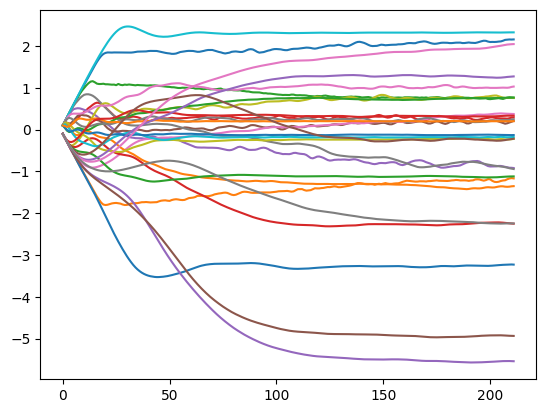

In [25]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        jmstate.jobs.Fit(lr=0.1),
        jmstate.jobs.LogParamsHistory(),
        jmstate.jobs.ParamStop(),
    ],
    max_iterations=500,
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [26]:
print(model.params_)
model.params_.get_cov("Q")

ModelParams(gamma=tensor([ 2.1573, -1.1671,  0.7659]), Q_repr=MatRepr(flat=tensor([ 0.2903, -0.9184,  0.2090,  0.3738, -0.9424,  0.7565]), dim=3, method='full'), R_repr=MatRepr(flat=tensor([2.3264]), dim=1, method='ball'), alphas={(2, 3): tensor([-3.2286]), (1, 2): tensor([-1.3518]), (0, 1): tensor([0.7650]), (0, 2): tensor([-2.2493]), (1, 3): tensor([-5.5395]), (0, 3): tensor([-4.9341])}, betas={(2, 3): tensor([1.0301, 0.2449]), (1, 2): tensor([-0.2226, -0.1748]), (0, 1): tensor([-0.1297,  0.2014]), (0, 2): tensor([-1.1189,  0.3329]), (1, 3): tensor([ 1.2727, -0.2164]), (0, 3): tensor([ 2.0460, -2.2438])})


tensor([[0.8835, 0.4937, 0.0541],
        [0.4937, 0.7872, 0.1684],
        [0.0541, 0.1684, 0.2202]])

tensor([ 2.1573, -1.1671,  0.7659])


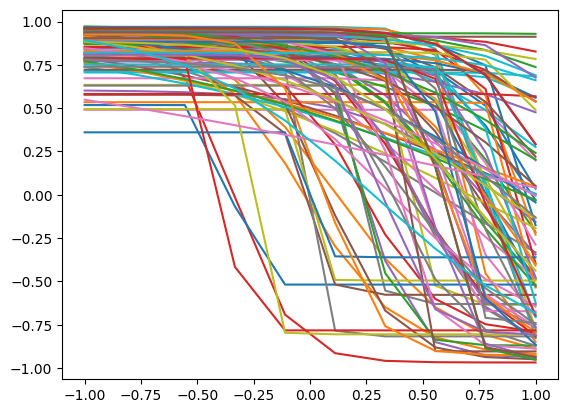

In [34]:
n_test = 100
t_test = torch.linspace(-1, 1, 10)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(3), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = x[:n_test]
b_test = Q_dist.sample((n_test,))
psi_test = model_design.individual_effects_fn(model.params_.gamma, x_test, b_test)
trajectories_init_test = [[trajectories[i][0]] for i in range(n_test)]
print(model.params_.gamma)
y_test = model_design.regression_fn(t_test, psi_test)
y_test += 0 * R_dist.sample(y_test.shape[:-1])
plt.plot(t_test, y_test[:, :, 0].T)
plt.show()

In [28]:
sample_data_test = SampleData(x_test, trajectories_init_test, psi_test)
trajectories_test = model.sample_trajectories(
    sample_data_test, torch.full((len(trajectories_init_test), 1), 1.0)
)